## 2024年 大谷翔平 ホームラン数予測モデル (2024-09-25時点)

### 1. Webからのデータ取得、HTMLの解析、データのクリーンアップと整形

In [1]:
# 必要なライブラリのインポート
import requests                            # Webページのコンテンツを取得するためのライブラリ
from bs4 import BeautifulSoup              # HTMLやXMLファイルを解析するためのライブラリ
import pandas as pd                        # データを扱うためのライブラリ (今回は使われていないが、分析用にインポートされている)
import warnings                            # 警告を処理するためのライブラリ
warnings.filterwarnings('ignore')          # 警告メッセージを無視する設定

# 大谷翔平 2024シーズンの全打席結果を取得するためのURL
url = "https://times.abema.tv/articles/-/10018233"

# Webページからデータを取得
res = requests.get(url)                    # 指定されたURLからHTMLを取得
soup = BeautifulSoup(res.content, "lxml")  # BeautifulSoupを使ってHTMLを解析 ("lxml"はHTML解析のパーサー)
table = soup.table                         # ページ内の最初の<table>タグを取得

# テーブルの列名を設定
columns = ['日付', '対戦相手', '打順', '第1', '第2', '第3', '第4', '第5', '第6', '第7']  # テーブルのカラム名を定義
data = []  # データを格納するためのリスト

# テーブルのすべての<tr>タグを取得し、繰り返し処理を行う
trs = table.find_all("tr")
for tr in trs[1:]:                         # 最初の行はヘッダー行なので、それを除外して処理
    tds = tr.find_all(["td", "th"])        # 各行の<td>や<th>タグを取得
    
    # "なし" または "中止" の文字列が含まれていたら、その行は無視する
    if "なし" in str(tds) or "中止" in str(tds):
        continue
    
    # 各セルのテキストから不要な改行や空白を削除して、一時的なリストに格納
    tmp = [td.text.replace("\xa0", "").replace("\n", "").replace("\r", "").replace("\t", "") for td in tds]
    
    # 特定の文字を置き換える処理 ("ニ"を"二"に置き換え、"2"や"3"も漢数字に置き換える)
    tmp = tmp[0:3] + [t.replace("ニ", "二").replace("2", "二").replace("3", "三") for t in tmp[3:]]
    
    # データが11列以上の場合は、10列目までに絞る
    if len(tmp) >= 11:
        tmp = tmp[:10]
    
    # クリーンアップされたデータをリストに追加
    data.append(tmp)

# クリーンアップされたデータを更に処理して、新たな形式で格納
data2 = []
for d in data:
    t1, t2 = d[0:3], d[3:]                 # 最初の3列 (日付、対戦相手、打順) と、それ以降のデータに分ける
    for t in t2:
        if "" != t:                        # 空のデータが含まれていない場合のみ処理
            data2.append(t1 + [t])         # 1行のデータとして追加

# 最初の2行のデータを確認 (デバッグ用)
data2[0:2]


[['3月20日', 'パドレス', '2指', '遊ゴ'], ['3月20日', 'パドレス', '2指', '右安']]

### 2. 大谷翔平選手の打席データを効率的に分析する
- 様々な統計情報（本塁打数、ヒット数、打率など）を計算するための一連の処理を行う
- 打席の結果をDataFrameとして整理し、各種の統計情報を追加した形で表示する

In [2]:
# 前のステップで作成したデータをDataFrameに変換し、列名を指定
df = pd.DataFrame(data2, columns=["date", "match", "order", "result"])

# 日本語の日付（例: "7月21日"）を西暦の日付形式（例: "2024-07-21"）に変換する関数
def convert_date(date_str):
    month, day = date_str.replace("日", "").split("月")  # "月"と"日"を除去して、月と日を分割
    return f"2024-{int(month):02}-{int(day):02}"         # "2024-月-日" の形式に整える

# 'date'列の日付データを変換し、標準のdatetime形式にする
df['date'] = df['date'].apply(convert_date)  # 日付変換関数を適用
df['date'] = pd.to_datetime(df['date'])  # 文字列からdatetime型に変換

# 本塁打の結果を判定し、'本'の文字が含まれる場合は 1 を、含まれない場合は 0 を設定
df['home_run'] = df['result'].apply(lambda x: 1 if '本' in x else 0)

# 安打の結果を判定し、'安'の文字が含まれる場合は 1 を、含まれない場合は 0 を設定
df['hit1'] = df['result'].apply(lambda x: 1 if '安' in x else 0)

# 2塁打の結果を判定し、結果が "二" で終わる場合は 1 を、それ以外の場合は 0 を設定
df['hit2'] = df['result'].apply(lambda x: 1 if x.endswith('二') else 0)

# 3塁打の結果を判定し、結果が "三" で終わる場合は 1 を、それ以外の場合は 0 を設定
df['hit3'] = df['result'].apply(lambda x: 1 if x.endswith('三') else 0)

# 打席数に影響しない用語のリスト
terms = ['四球', '敬遠', '死球', '打妨', '中犠', '右犠', '左犠']

# 打数を判定し、'terms'のいずれかに含まれていれば 0、そうでなければ 1 を設定
df['flag'] = df['result'].apply(lambda x: 0 if x in terms else 1)

# 打席数の累積計算 (cumsum関数を使用して打席数を累積する)
df['strokes'] = df['flag'].cumsum()

# ヒットの累積数を計算 (hit1, hit2, hit3列の合計を累積)
df['hit_total'] = df[['hit1', 'hit2', 'hit3']].sum(axis=1).cumsum()

# ホームランの累積数を計算 (home_run列を累積)
df['home_run_total'] = df['home_run'].cumsum()

# 打率を計算 (累積ヒット数を累積打席数で割る)
df['average'] = df[['hit_total', 'home_run_total']].sum(axis=1) / df['strokes']

# 最後の5行を表示 (最終的な統計結果)
print(df.tail())


,date,match,order,result,home_run,hit1,hit2,hit3,flag,strokes,hit_total,home_run_total,average
702,2024-09-23,ロッキーズ,1指,中本,1,0,0,0,1,611,131,53,0.301146
703,2024-09-25,パドレス,1番,右二,0,0,1,0,1,612,132,53,0.302288
704,2024-09-25,パドレス,1番,四球,0,0,0,0,0,612,132,53,0.302288
705,2024-09-25,パドレス,1番,左飛,0,0,0,0,1,613,132,53,0.301794
706,2024-09-25,パドレス,1番,空振,0,0,0,0,1,614,132,53,0.301303


### 3. 指定されたデータフレームから打率の推移を折れ線グラフで可視化する

In [3]:
import altair as alt  # インタラクティブなデータ可視化ライブラリ

# Altairで折れ線グラフを作成
#'df'は先ほど作成したデータフレーム, 折れ線グラフを描画する
chart = alt.Chart(df).mark_line().encode(
    x='date',                        # x軸に 'date' 列 (日付) を指定
    y='average'                      # y軸に 'average' 列 (打率) を指定
).properties(
    title='Time Series of Average',  # グラフのタイトルを設定
    width=800                        # グラフの幅を800ピクセルに設定
)

# グラフを表示
# Jupyter Notebookや互換環境で実行する際に使われる, 他の環境ではchart.show()やchart.save()を使う場合もある
chart.display()

alt.Chart(...)

### 4. 打率とホームランの累積数の2つの異なる指標の折れ線グラフ

In [4]:
# 打率(average)の折れ線グラフ
# 青色の折れ線グラフを作成し、y軸に打率(average)を設定
average_line = alt.Chart(df).mark_line(color='blue').encode(
    x='date',                                                         # x軸には日付を設定
    y=alt.Y('average', axis=alt.Axis(title='Average'))                # y軸には打率を設定し、軸のタイトルを"Average"にする
)

# ホームラン数の累積(home_run_total)の折れ線グラフ
# 赤色の折れ線グラフを作成し、y軸にホームラン累積数(home_run_total)を設定
home_run_line = alt.Chart(df).mark_line(color='red').encode(
    x='date',                                                         # x軸には日付を設定
    y=alt.Y('home_run_total', axis=alt.Axis(title='Home Run Total'))  # y軸にはホームラン累積数を設定し、軸のタイトルを"Home Run Total"にする
)

# 二重軸のグラフを作成
# average_line(打率)とhome_run_line(ホームラン累積)の2つの折れ線グラフを重ねて表示
chart = alt.layer(
    average_line,                                       # 打率の折れ線グラフ
    home_run_line                                       # ホームラン累積の折れ線グラフ
).resolve_scale(
    y='independent'                                     # y軸のスケールを独立させ、2つの異なるy軸を使う
).properties(
    title='Time Series of Average and Home Run Total',  # グラフのタイトルを設定
    width=800                                           # グラフの幅を800ピクセルに設定
)

# グラフを表示
chart.display()


alt.LayerChart(...)

### 5. ARIMAモデルを用いてホームランの累積数を予測し、結果を視覚化する
- ARIMA = 自己回帰和分移動平均
- 実際のデータと予測データを重ねて表示することで、モデルの予測精度を視覚的に評価することができる

#### ARIMAモデルの定義式:

$
Y_t - Y_{t-d} = c + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \ldots + \phi_p Y_{t-p} + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \ldots + \theta_q \varepsilon_{t-q}
$


| 記号             | 説明                                                                 |
|------------------|----------------------------------------------------------------------|
| $ Y_t $        | 時刻 $ t $ における観測値（ホームランの累積数）                      |
| $ Y_{t-d} $    | 時刻 $ t-d $ における観測値（時系列の差分）                           |
| $ \phi_i $     | 自己回帰係数（AR部分の係数）                                          |
| $ \theta_j $   | 移動平均係数（MA部分の係数）                                          |
| $ p $          | 自己回帰項の次数（ARのラグの数）                                      |
| $ d $          | 差分の次数（トレンド除去のために取る差分の回数）                        |
| $ q $          | 移動平均項の次数（MAのラグの数）                                      |
| $ \varepsilon_t $ | 時刻 $ t $ における誤差項（ホワイトノイズ）                       |
| $ c $          | 定数項                                                                  |


#### ARIMA(p, d, q)モデルの定義式:
$
Y_t - Y_{t-d} = c + \sum_{i=1}^{p} \phi_i Y_{t-i} + \sum_{j=1}^{q} \theta_j \varepsilon_{t-j} + \varepsilon_t
$

| 記号            | 説明                                    |
|-----------------|-----------------------------------------|
| $ Y_t $         | 時刻 $ t $ における観測値             |
| $ Y_{t-d} $     | 時刻 $ t-d $ における観測値（$ d $ 階差を表す）|
| $ c $           | 定数項（切片）                          |
| $ \phi_i $      | 自己回帰係数（AR成分）                  |
| $ Y_{t-i} $     | 時刻 $ t-i $ における観測値           |
| $ \theta_j $    | 移動平均係数（MA成分）                  |
| $ \varepsilon_{t-j} $ | 時刻 $ t-j $ における誤差項 |
| $ \varepsilon_t $ | 時刻 $ t $ における誤差項         |


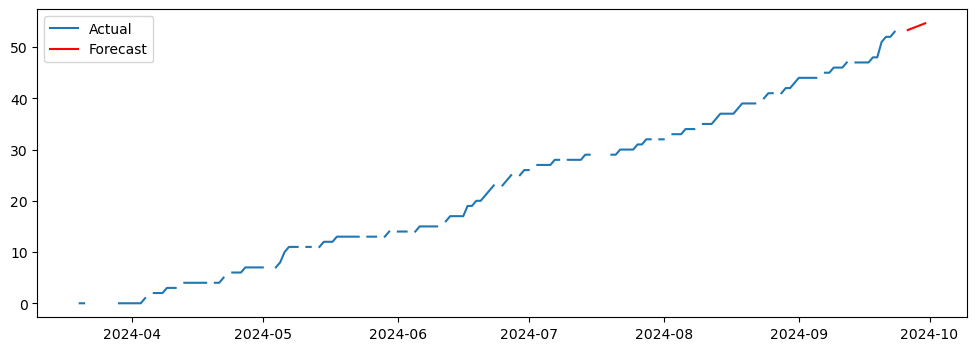

In [5]:
from statsmodels.tsa.arima.model import ARIMA  # 時系列分析用のARIMAモデルライブラリ
import matplotlib.pyplot as plt                # グラフ描画用のライブラリ

# 予測データのプロットを関数化
def plot_forecast(df, forecast, steps, label='Forecast', color='red'):
    # pd.date_rangeで予測日付範囲を作成し、それに対応する予測値をプロット
    forecast_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=steps, freq='D')
    # 予測結果をプロット
    plt.plot(forecast_dates, forecast, label=label, color=color)  

# 元のデータフレームをコピーし、日付をインデックスに設定する
df2 = df.copy()                                # データフレームをコピーして編集する
df2 = df.groupby('date').max()                 # 日付ごとにデータを最大値で集計する

# 欠損している日付を埋めて、日付を連続させる（"asfreq('D')"で日付の頻度を1日単位に設定）
df2 = df2.asfreq('D')                          # 欠損日付を追加し、連続した日付のデータに変換

# ARIMAモデルのフィッティング (order=(1, 1, 1)でモデルのパラメータを指定)
# ARIMAは時系列データに適した予測モデルで、(p, d, q)の順にパラメータを設定する
model = ARIMA(df2['home_run_total'], order=(1, 1, 1))
model_fit = model.fit()                        # モデルをデータにフィットさせる

# 5日先までのホームラン累積数を予測
forecast = model_fit.forecast(steps=5)         # 5日間の予測を行う

# 結果のプロット（グラフ描画）
plt.figure(figsize=(12, 4))                    # グラフのサイズを指定
plt.plot(df2.index, df2['home_run_total'], label='Actual')  # 実際のホームラン累積数をプロット

# プロット関数を使用して予測結果をプロット
plot_forecast(df2, forecast, steps=5)

plt.legend()  # 凡例を表示
plt.show()    # グラフを表示


### 6. 残り試合での日別予測結果を表示

In [6]:
# 予測結果を表示
forecast_dates = pd.date_range(df2.index[-1] + pd.Timedelta(days=1), periods=5, freq='D')  # 予測日付を生成
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast': forecast})  # 予測結果をデータフレームに変換

# 日別で予測結果テーブルを表示
import IPython.display as display  # Jupyter Notebookの表示用ライブラリ
display.display(forecast_df.style.set_table_attributes('style="width: 50%; margin: auto;"').set_caption("Forecasted Home Runs for Upcoming Days"))


,Date,Forecast
2024-09-26 00:00:00,2024-09-26 00:00:00,53.329997
2024-09-27 00:00:00,2024-09-27 00:00:00,53.659815
2024-09-28 00:00:00,2024-09-28 00:00:00,53.989453
2024-09-29 00:00:00,2024-09-29 00:00:00,54.318912
2024-09-30 00:00:00,2024-09-30 00:00:00,54.648192


### 7. 以上から、予測ホームラン数は　54.648192